# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


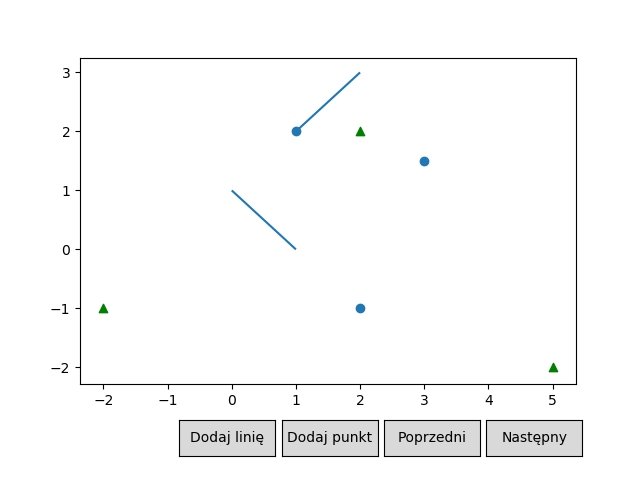

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


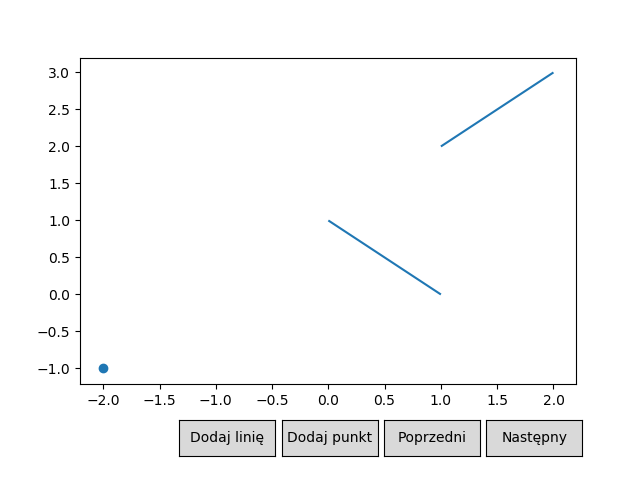

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


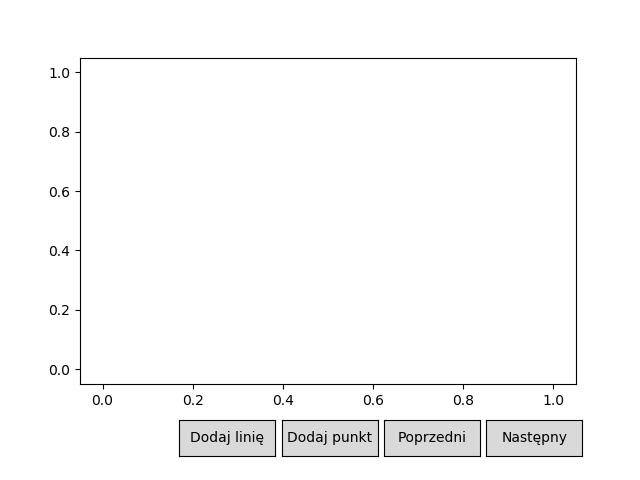

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


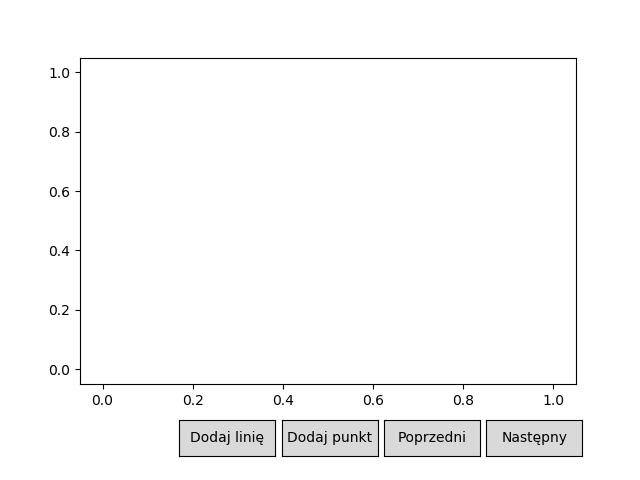

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [7]:
def det1(line,point):
    a=line[0]
    b=line[1]
    c=point
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

In [8]:
def checkInterline(det,eps):
    if (det<eps and det>-eps):
        return True
    else:
        return False

In [9]:
def intersect(lineA,lineB,eps):
    X1=lineA[0][0]
    X2=lineA[1][0]
    X3=lineB[0][0]
    X4=lineB[1][0]
    Y1=lineA[0][1]
    Y2=lineA[1][1]
    Y3=lineB[0][1]
    Y4=lineB[1][1]
    
    A1 = (Y1-Y2)/(X1-X2) 
    A2 = (Y3-Y4)/(X3-X4) 
    b1 = Y1-A1*X1
    b2 = Y3-A2*X3
    
    if(A1==A2):
        return (False,(0,0))
    else:
        Xa = (b2 - b1) / (A1 - A2) 
        Ya = A1 * Xa + b1
        if (checkInterline(det1(lineA,(Xa,Ya)),eps) and
            checkInterline(det1(lineB,(Xa,Ya)),eps)):
            
            return (True,(Xa,Ya))
        else:
            return (False,(0,0)) 
        

In [10]:
def isOnLine(lineA,lineB,point):
    X1=lineA[0][0]
    X2=lineA[1][0]
    X3=lineB[0][0]
    X4=lineB[1][0]
    Y1=lineA[0][1]
    Y2=lineA[1][1]
    Y3=lineB[0][1]
    Y4=lineB[1][1]
    Xa = point[0] 
    Ya = point[1]
    if ( (Xa < max( min(X1,X2), min(X3,X4) )) or
         (Xa > min( max(X1,X2), max(X3,X4) )) ):
        return False
    else:
        return True

In [11]:
def checkSameX (lineA):
    return lineA[0][0]==lineA[1][0]

In [12]:
def checkSameEnd (lineA,lineB):
    return (lineA[0][0]==lineB[0][0] and lineA[0][1]==lineB[0][1] or lineA[1][0]==lineB[1][0] and lineA[1][1]==lineB[1][1] or
            lineA[1][0]==lineB[0][0] and lineA[1][1]==lineB[0][1] or lineA[0][0]==lineB[1][0] and lineA[0][1]==lineB[0][1])

In [13]:
l1=((1,1),(1,2))
checkSameX(l1)

True

In [14]:
l1=((4,5),(1,1))
l2=((1,1),(3,2))

checkSameEnd(l1,l2)

True

<IPython.core.display.Javascript object>


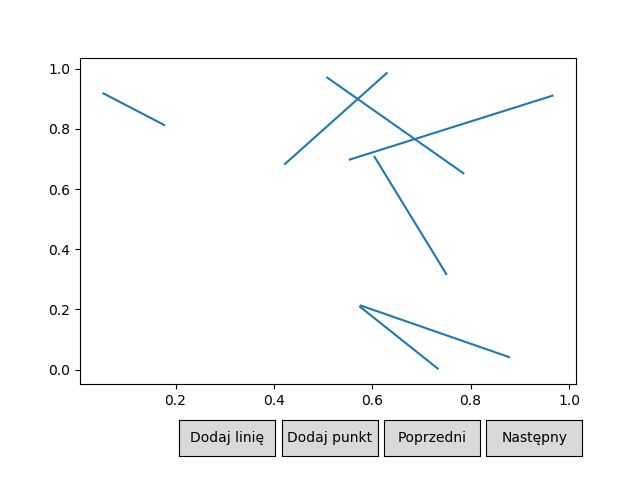

In [15]:
%matplotlib notebook
import random
def generateDisconectedVectors(x1,y1,x2,y2,n,fileName=-1):
    lines=[]
    i=0
    while (i < n):
        good=True
        newX1=random.uniform(x1,x2)
        newX2=random.uniform(x1,x2)
        newY1=random.uniform(y1,y2)
        newY2=random.uniform(y1,y2)
        if(newX1>newX2):
            newX1,newX2=newX2,newX1
        newLine=((newX1,newY1),
                      (newX2,newY2))
        
        for line in lines:
            if((checkSameX(newLine))):
                good=False
            else:
                if ((checkSameEnd(newLine,line))):
                    good=False
        if (good):
            lines.append(newLine)
            i+=1
    if(fileName!=-1):
        plot=Plot([Scene(lines=[LinesCollection(lines)])])
        with open(fileName +'.json', 'w') as file:
            file.write(plot.toJson())
    return lines
linesA=generateDisconectedVectors(0,0,1,1,7)

scenes=[Scene(lines=[LinesCollection(linesA)])]
plot = Plot(scenes)
plot.draw()
#[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]

In [16]:
from sortedcontainers import SortedDict
from sortedcontainers import SortedSet

defEps=10**-4
def sweepingAll(linesList):
    if len(linesList) <2:
        return ([],[])
    scenes=[]
    activeLines=SortedSet([],key=lambda x: x[0][1])
    minY=linesList[0][0][1]
    maxY=linesList[0][0][1]
    events=[]
    yLineDict=SortedDict()
    for [p1,p2] in linesList:
        events.append(((p1,p2),"start"))
        events.append(((p2,p1),"end"))
        minY=min(minY,p1[1],p2[1])
        maxY=max(maxY,p1[1],p2[1])
        yLineDict[(p1,p2)]=p1[1]
    
    Q=SortedSet(events, key=lambda x:(x[0][0],x[0][1]))
    T=SortedSet([],key=lambda x:x[1])
    intersectionPoints=SortedSet([],key=lambda x: x[0])
    sweepX=Q[0][0][0][0]
    sweep=[[(sweepX,minY),(sweepX,maxY)]]
    
    currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
                       [LinesCollection(linesList),LinesCollection(sweep,color='black')])
    scenes.append(currentScene)
    
    j=1
    while Q:
        event=Q.pop(0)
        sweepX=event[0][0][0]
        sweep=[[(sweepX,minY),(sweepX,maxY)]]
        #print("iteracja:",j,event)
        #for x in T:
            #print(x)
        
        if event[1]=="start":
            
            startLine=event[0]
            activeLines.add(startLine)
            T.add((startLine, startLine[0][1]))
            i=T.index((startLine, startLine[0][1]))
            n=len(T)
            
            if i-1>=0:
                neighbour=T[i-1][0]
                (intersects, interPoint)= intersect(startLine,neighbour,defEps)
                
                if intersects and isOnLine(startLine,neighbour,interPoint) and interPoint[0] > sweepX:
                    Q.add(((interPoint,startLine,neighbour),"intersection"))
                    intersectionPoints.add(interPoint)
                    
            if i+1 < n:
                neighbour=T[i+1][0]
                (intersects, interPoint)= intersect(startLine,neighbour,defEps)

                if intersects and isOnLine(startLine,neighbour,interPoint)and interPoint[0] > sweepX:
                    Q.add(((interPoint,startLine,neighbour),"intersection"))
                    intersectionPoints.add(interPoint)
                    
        elif event[1]=="end":
            startLine=event[0]
            startLine=(startLine[1],startLine[0])
            activeLines.remove(startLine)
            i=T.index((startLine, yLineDict[startLine]))
            T.remove((startLine, yLineDict[startLine]))
            n=len(T)
            
            if i-1>=0 and i <n:
                neighbour1=T[i-1][0]
                neighbour2=T[i][0]
                (intersects, interPoint)= intersect(neighbour1,neighbour2,defEps)
                
                if intersects and isOnLine(neighbour1,neighbour2,interPoint) and interPoint not in intersectionPoints and interPoint[0] > sweepX:
                    Q.add(((interPoint,neighbour1,neighbour2),"intersection"))
                    intersectionPoints.add(interPoint)
                    
        else:
            firstLine=event[0][1]
            secondLine=event[0][2]
            i2=T.index((firstLine,yLineDict[firstLine]))
            i1=T.index((secondLine,yLineDict[secondLine]))
            T.remove((firstLine,yLineDict[firstLine]))
            T.remove((secondLine,yLineDict[secondLine]))

            yLineDict[firstLine],yLineDict[secondLine] = yLineDict[secondLine],yLineDict[firstLine]

            T.add((firstLine,yLineDict[firstLine]))
            T.add((secondLine,yLineDict[secondLine]))
            n=len(T)
            
            
            if i1-1>=0 and i1-1 is not i2:
                neighbour=T[i1-1][0]
                (intersects, interPoint)= intersect(neighbour,firstLine,defEps)

                if intersects and isOnLine(neighbour,firstLine,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
                    Q.add(((interPoint,neighbour,firstLine),"intersection"))
                    intersectionPoints.add(interPoint)
                
            if i1+1<n and i1+1 is not i2:
                neighbour=T[i1+1][0]
                (intersects, interPoint)= intersect(firstLine,neighbour,defEps)

                if intersects and isOnLine(firstLine,neighbour,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
                    Q.add(((interPoint,firstLine,neighbour),"intersection"))
                    intersectionPoints.add(interPoint)
                
            if i2-1>=0 and i2-1 is not i1:
                neighbour=T[i2-1][0]
                (intersects, interPoint)= intersect(neighbour,secondLine,defEps)

                if intersects and isOnLine(neighbour,secondLine,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
                    Q.add(((interPoint,neighbour,secondLine),"intersection"))
                    intersectionPoints.add(interPoint)
                
            if i2+1<n and i2+1 is not i1:
                neighbour=T[i2+1][0]
                (intersects, interPoint)= intersect(secondLine,neighbour,defEps)

                if intersects and isOnLine(secondLine,neighbour,interPoint) and interPoint not in intersectionPoints  and interPoint[0] > sweepX:
                    Q.add(((interPoint,secondLine,neighbour),"intersection"))
                    intersectionPoints.add(interPoint)
                    
        currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
                       [LinesCollection(linesList),LinesCollection(sweep,color='black'),LinesCollection([[x[0],x[1]] for x in activeLines],color='red')])
        scenes.append(currentScene)
        j=j+1
    print('Liczba wykrytych punktów przecięcia: ' + str(len(intersectionPoints)) )
    for x in intersectionPoints:
        print(x)
    print()
        
    currentScene=Scene([PointsCollection([x for x in intersectionPoints],color='green')],
                       [LinesCollection(linesList),LinesCollection(sweep,color='black')])
    scenes.append(currentScene)
                    
    return (intersectionPoints, scenes)

Liczba wykrytych punktów przecięcia: 3
(0.5704580280076321, 0.8995107347030663)
(0.6864675216413036, 0.7662509517522458)
(0.6864675216413036, 0.766250951752246)



<IPython.core.display.Javascript object>


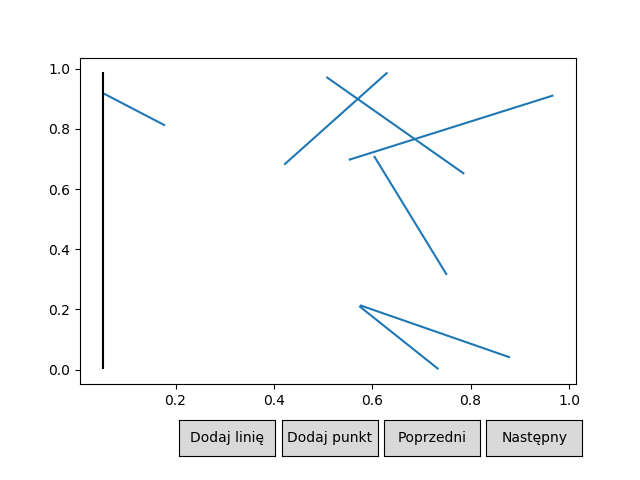

In [17]:
result=sweepingAll(linesA)

plot = Plot(result[1])
plot.draw()

[((-2, 2), (2, -2)), ((-2, -2), (2, 2)), ((-1.5, 1), (-1, 0)), ((-1.5, -1), (-0.25, -0.15))]
[((0.6036380650100409, 0.709995241287209), (0.7515995035454307, 0.3147057780888065)), ((0.05160304687255712, 0.9197275403227407), (0.17865646842376104, 0.8115872841012755)), ((0.5735878093006953, 0.2108744372275041), (0.7346443647682466, 0.001241376543343331)), ((0.5750502063730701, 0.21375418369050792), (0.8801091464695797, 0.04030912364176187)), ((0.5067595609554506, 0.9726809867901759), (0.787124537160034, 0.6506265177480784)), ((0.5522108578341783, 0.697079487536469), (0.9684556365484693, 0.9115363345887899)), ((0.42108845455308364, 0.6813565283831189), (0.6309376801600813, 0.9878412441146018))]


<IPython.core.display.Javascript object>


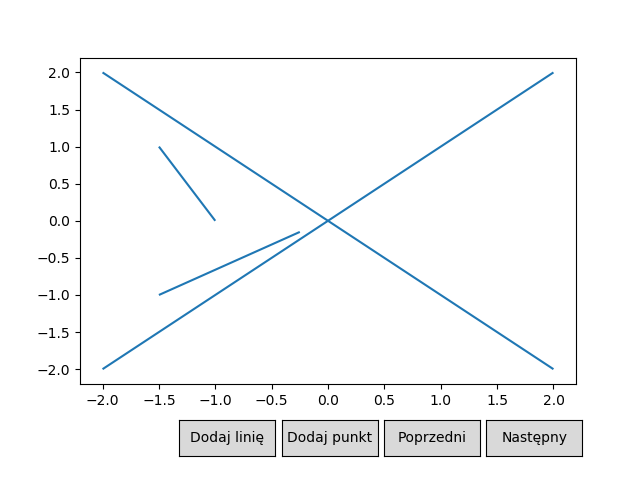

In [57]:
linesCollection=[]
linesCollection.append(((-2,2),(2,-2)))
linesCollection.append(((-2,-2),(2,2)))
linesCollection.append(((-1.5,1),(-1,0)))
linesCollection.append(((-1.5,-1),(-0.25,-0.15)))

scenes=[Scene(lines=[LinesCollection(linesCollection)])]
plot = Plot(scenes)
plot.draw()



Liczba wykrytych punktów przecięcia: 1
(-0.0, 0.0)



<IPython.core.display.Javascript object>


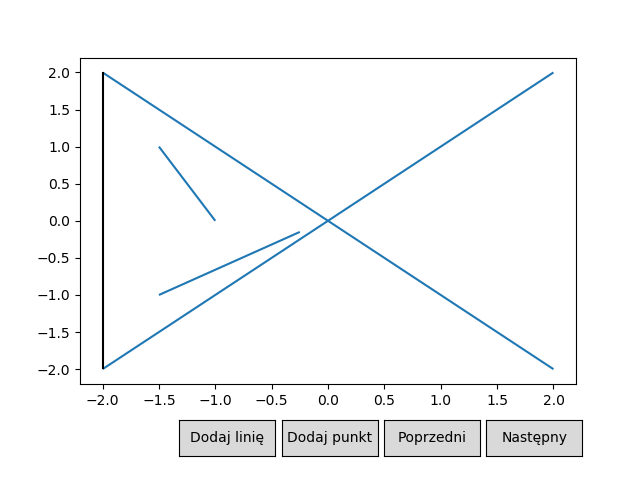

In [59]:
result=sweepingAll(linesCollection)
plot = Plot(result[1])
plot.draw()

In [60]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)